# Climate Dataset is a time series collection of annual attributes 

# <span style = 'color:blue'>Steps:-</span>

## <span style='color:red'>Phase A: Data wrangling & preparation</span>
- Read excel sheet into pandas
- Index with Country Code and Year
- fill empty cells (Preferably using Exponential Weightage + add error as resampled with number of entries)
- Normalize columns (No need to use the same data frame , but we can fill the empty values in calculation)

## <span style='color:red'>Phase B: Data Exploration phase - Understand and Analyse Correlation </span>
- Draw scatter Plot matrix across columns
- develop CLUSTERING to analyze similar segments (May be segmenting regions with similar Pollution level)

** Pollution Index **
- There are few pollutants and related indicators(CO2 emissions (kt)/CO2 emissions (metric tons per capita),Methane emissions (kt of CO2 equivalent),Nitrous oxide emissions (thousand metric tons of CO2 equivalent),Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)
- Polluting Index = sum of (Exponential weightage EWMA of all of these elements)/World Pollution contents (sum of all contents)  

** CORRELATION Analysis **
- Find out CORRELATION COEFFICIENTS amongst all pertinents attributes/variablesfor all TOP Polluting countries
- Analyze high CORRELATIONS between attributes
- Apply domain knowledge for CORRELATION and CAUSATIVE Analysis and give reccomendation

## <span style='color:red'>Phase C: Modeling phase - Forecast, Trending , Visualization, Conclusion</span>
- We take dataset , combine all polluting elements , build one PREDICTIONN Model using Linear Regression with adequate degree (Balanced approach so its not OVERFITTING) and plot both the curve indicating CYRRENT Pollution data and PREDICTION

In [166]:
#########################################
## Import important function ############
#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [21]:
import datetime as dt

In [22]:
import statsmodels.tsa.stattools as smtsa

## Read excel sheet (1) Main sheet - sheet no. '0' for pollution detail and (2) Country code dictionary for COUNTRY CODES 

In [23]:
dict_country=pd.read_excel('E:/Niraj/Niraj Personal/Learnings/Machine Learning/Data Science Competition/Pollution_Dataset_FINAL.xlsx',sheetname=2)

In [24]:
poll_data=pd.read_excel('E:/Niraj/Niraj Personal/Learnings/Machine Learning/Data Science Competition/Pollution_Dataset_FINAL.xlsx')

In [25]:
dict_country.head()

,Country Code,Region,EconomicCategory,CountryCode Name,Notes
0,ABW,Latin America & Caribbean,High income,Aruba,NaN
1,AFG,South Asia,Low income,Afghanistan,NaN
2,AGO,Sub-Saharan Africa,Lower middle income,Angola,NaN
3,ALB,Europe & Central Asia,Upper middle income,Albania,NaN
4,AND,Europe & Central Asia,High income,Andorra,NaN


In [26]:
############################################################
# Create Index using country code and year #################
############################################################
poll_data.set_index(['country_code','year'],inplace=True)
dict_country.set_index(['Country Code'],inplace=True)


In [27]:
##################################################################
# This function calculates exponential weightage moving average###
# This will return the last value as the most trending value #####
# ################################################################

def ewm_avg(data_series):
    avg_val=data_series.ewm(span=5).mean()
    return(avg_val[-1])

# Pollution Index = Sum of all major 4 POLLUTANTS (take the TRENDING values for each country) / World's 4 POLLUTANTS sum

In [28]:
#################################################################################################################
# Determine top 20 maximum polluting countries
# Analyze their data attributes
# Polluting Index = AVG(Moving Average of a.#CO2 emissions (kt)/CO2 emissions (metric tons per capita),
#                 b. Methane emissions (kt of CO2 equivalent),c. Nitrous oxide emissions (thousand metric tons of CO2 equivalent),
#                 d. Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent) )
#################################################################################################################
co2_ewm=poll_data['CO2 emissions (kt)'].groupby(['country_code']).apply(ewm_avg)
methane_ewm=poll_data['Methane emissions (kt of CO2 equivalent)'].groupby(['country_code']).apply(ewm_avg)
n2o_ewm=poll_data['Nitrous oxide emissions (thousand metric tons of CO2 equivalent)'].groupby(['country_code']).apply(ewm_avg)
others_ewm=poll_data['Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)'].groupby(['country_code']).apply(ewm_avg)

total_pollution=co2_ewm+methane_ewm+n2o_ewm+others_ewm

# POLLUTION Index Visualization of top 19 COUNTRIES

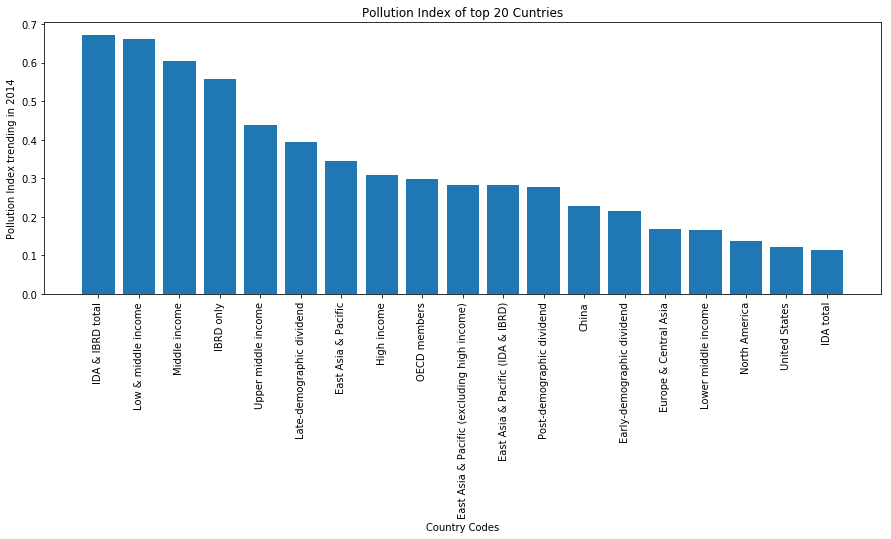

In [29]:
plt.figure(figsize=(15,5))
world_pollution=total_pollution.dropna().sort_values(ascending=False)[0]
country_pollution_ratio=total_pollution.dropna().sort_values(ascending=False)[1:20]/world_pollution
plt.bar(left=range(len(country_pollution_ratio)),height=country_pollution_ratio.values,
        tick_label=dict_country.loc[country_pollution_ratio.index]['CountryCode Name'].values)

plt.xticks(rotation=90)
plt.title('Pollution Index of top 20 Cuntries')
plt.xlabel('Country Codes')
plt.ylabel('Pollution Index trending in 2014')


# Break down of 4 Pollutants for top 19 COUNTRIES

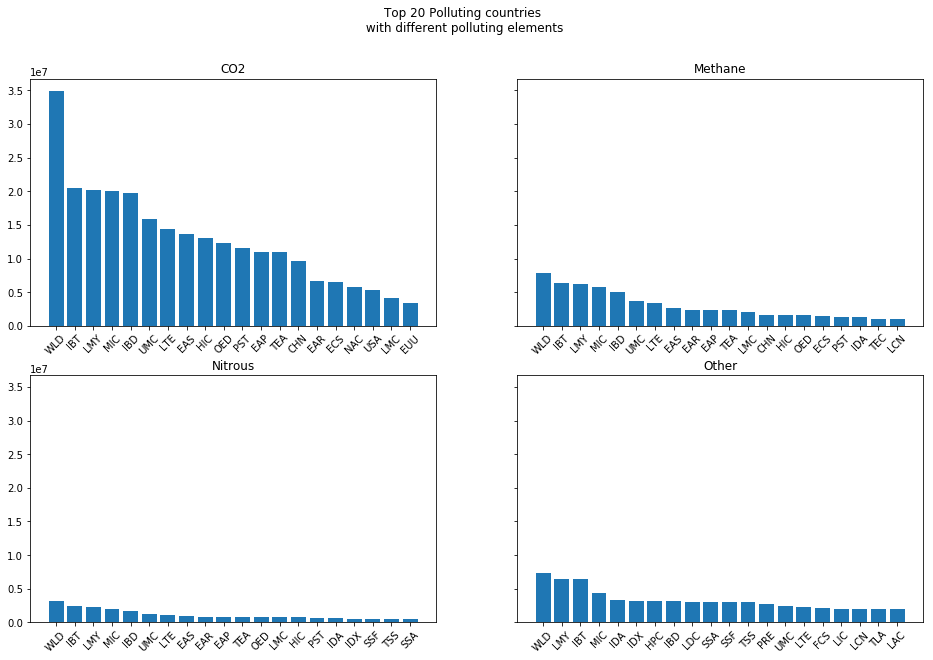

In [30]:
fig,axes=plt.subplots(2,2,figsize=(16,10),sharey=True)

list_poll_names=[co2_ewm,methane_ewm,n2o_ewm,others_ewm]
for poll_name,ax in zip(list_poll_names,axes.ravel()):
    poll_name=poll_name.dropna().sort_values(ascending=False)[:20]
    ax.bar(left=range(len(poll_name)),height=poll_name.values,tick_label=poll_name.index)
    ax.set_xticklabels(poll_name.index,rotation=45)
    ax.set_title(poll_name.name.split()[0]) 
fig.suptitle('Top 20 Polluting countries\n with different polluting elements')


# <span style='color:red'>From the above pollution index, let's analyze how top polluting countries are related to some of civil, geologcal factors</span>
# CORRELATION - How are attributes correlated 

In [31]:
# Create one dictionary variable
# create an array with all pertinent variables we would like to get the CORRELATION
# four items - country, var1,var2 and correlation coefficient
# Loop through each country 
# Create Correlation for each country for each pair of variables

var = ['Agricultural land (% of land area)','Arable land (% of land area)','CO2 emissions (metric tons per capita)',
       'CO2 emissions from gaseous fuel consumption (% of total)','CO2 emissions from liquid fuel consumption (% of total)',
       'CO2 emissions from solid fuel consumption (% of total)','Cereal yield (kg per hectare)','Electric power consumption (kWh per capita)',
       'Electricity production from coal sources (% of total)','Electricity production from hydroelectric sources (% of total)',
       'Electricity production from natural gas sources (% of total)','Electricity production from nuclear sources (% of total)',
       'Electricity production from oil sources (% of total)','Electricity production from renewable sources, excluding hydroelectric (% of total)',
       'Energy use (kg of oil equivalent per capita)','Foreign direct investment, net inflows (% of GDP)','Methane emissions (kt of CO2 equivalent)',
       'Mortality rate, under-5 (per 1,000 live births)','Nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
       'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)','Population growth (annual %)',
       'Total greenhouse gas emissions (kt of CO2 equivalent)','Urban population (% of total)','Urban population growth (annual %)']

In [32]:
dict_corr=dict()
keys=['country','var1','var2','corr_coeff']
for key in keys:
    dict_corr[key]=[]
    
total_count = 0
for count in country_pollution_ratio.index:
    counter_var=0
    for var1 in var[counter_var:]:
        counter_var+=1
        total_count+=1
        for var2 in var[counter_var:]:
            a= poll_data.loc[count][var1]
            b= poll_data.loc[count][var2]
            a=a.fillna(a.ewm(span=5).mean())
            b=b.fillna(b.ewm(span=5).mean())
            a=a.fillna(method='bfill')
            b=b.fillna(method='bfill')
            corr = np.round(np.corrcoef(a,b)[0,1],2)
            dict_corr['country'].append(count)
            dict_corr['var1'].append(var1)
            dict_corr['var2'].append(var2)
            dict_corr['corr_coeff'].append(corr)
        
print(total_count)


456


## <span style='color:red'>Finding out pairs of variables those are very much related</span>
- ** Get counts of pair of variables those CORRELATION COEFFICIENTS ate over 90% **
- ** We can change the CORRELATION THRESHOLD and find out those pair of variables those are CORRELATED **
- We have got a list of top 20 countries those have very high CORRELATION + or - amongst their variables
- ** Some Visual for TOP Countries and Analysis **

# <span style='color:brown'>Some Conclusion :</span>
- In EAST ASIA PACIFIC , there is strong correlation between CO2 emission and Energy use ( Please read the data in result set). This means if we use less Energy , probably CO2 emission will be less 
- In the result section below , There is a -ve strong CORRELATION between 'Arable land (% of land area)' and 'Electricity production from natural gas source' , probably means more ARABLE land is related to less of Electricity production from natural gas source, Probably this may have a causative relation , if folks are using more RABLE land , need to produce electricity using natural gas is less so less emission to CO2

In [33]:
###############################################################################################
### Picked up few variables those are having very strong correlation in certain countries #####
###############################################################################################

df2=pd.DataFrame(dict_corr,index=dict_corr['country'])
df2=df2.loc[np.greater(df2.corr_coeff.abs(),0.90)]
var_pair_count=df2.groupby(['country']).count()['var1']
df2.sort_values(['corr_coeff'],ascending=False).head()

###### Uncomment and run to see top CORRELATION values for specific top polluting coutries ########
#df2[df2.country=='HIC']


,corr_coeff,country,var1,var2
TEA,1.0,TEA,CO2 emissions (metric tons per capita),Energy use (kg of oil equivalent per capita)
EAP,1.0,EAP,Electric power consumption (kWh per capita),Energy use (kg of oil equivalent per capita)
CHN,1.0,CHN,CO2 emissions (metric tons per capita),Energy use (kg of oil equivalent per capita)
CHN,1.0,CHN,Methane emissions (kt of CO2 equivalent),Total greenhouse gas emissions (kt of CO2 equi...
TEA,1.0,TEA,Electric power consumption (kWh per capita),Energy use (kg of oil equivalent per capita)


In [34]:
df2.head()

,corr_coeff,country,var1,var2
IBT,0.92,IBT,Arable land (% of land area),CO2 emissions (metric tons per capita)
IBT,0.97,IBT,Arable land (% of land area),Cereal yield (kg per hectare)
IBT,0.91,IBT,Arable land (% of land area),Energy use (kg of oil equivalent per capita)
IBT,0.92,IBT,Arable land (% of land area),Methane emissions (kt of CO2 equivalent)
IBT,0.93,IBT,Arable land (% of land area),Nitrous oxide emissions (thousand metric tons ...


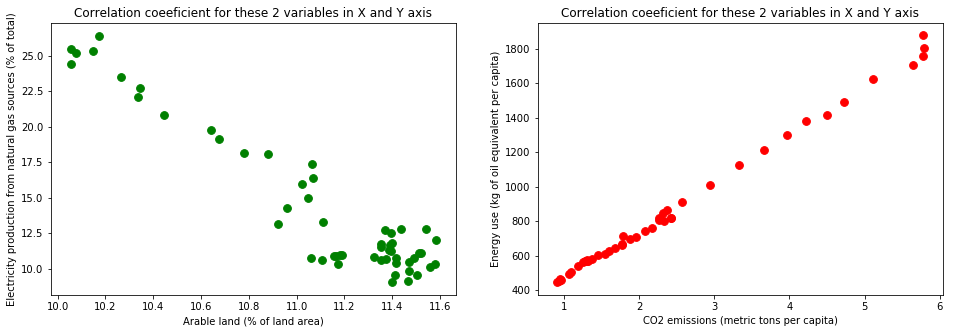

In [35]:
fig,axes=plt.subplots(1,2,figsize=(16,5))
v=['Arable land (% of land area)','Electricity production from natural gas sources (% of total)']
v1=poll_data.loc['HIC'][v[0]]
v2=poll_data.loc['HIC'][v[1]]
axes[0].scatter(v1,v2,c='g',s=60)
axes[0].set_xlabel(v[0])
axes[0].set_ylabel(v[1])
axes[0].set_title('Correlation coeeficient for these 2 variables in X and Y axis')

v=['CO2 emissions (metric tons per capita)','Energy use (kg of oil equivalent per capita)']
v1=poll_data.loc['EAP'][v[0]]
v2=poll_data.loc['EAP'][v[1]]
axes[1].scatter(v1,v2,c='r',s=60)
axes[1].set_xlabel(v[0])
axes[1].set_ylabel(v[1])
axes[1].set_title('Correlation coeeficient for these 2 variables in X and Y axis')


# Pollution Prediction Model
- we prepare the dataset by filling empty values (1) first take EXPONENTIAL Weighing average - This is better than straight average. This fills the empty value in the middle of list by weighing average taking windows size of 5 (2) Followed by using teh method of 'bfill'which is taking recent values 
- We can take WORLD Pollution data by taking the sum of all major 4 POLLUTING VARIABLES
- ** Use LINEAR REGRESSION and POLYNOMIAL Function **
- We use scikit learning package of LINEAR and Polynomial function
- DEGREE = 3 , we can vary degree and test which one will be the best yet not taking quite high to avoid OVERFITTING
- Transform year index to nth degree of polynomial as X
- y is the SUMMED POLLUTION Value
- Train the model using LINEAR Regression
- Plot the model using long line
- plot the original X values to see the contrast between ACTUAL POLLUTION value vs PREDICTION Line


In [262]:
world_name=total_pollution.sort_values(ascending=False).index[0]

poll_elements= ['CO2 emissions (kt)','Methane emissions (kt of CO2 equivalent)',
                'Nitrous oxide emissions (thousand metric tons of CO2 equivalent)',
                'Other greenhouse gas emissions, HFC, PFC and SF6 (thousand metric tons of CO2 equivalent)']

a=poll_data.loc[world_name][poll_elements[0]]
b=poll_data.loc[world_name][poll_elements[1]]
c=poll_data.loc[world_name][poll_elements[2]]
d=poll_data.loc[world_name][poll_elements[3]]

sum=0
for x in [a,b,c,d]:
    x=x.fillna(x.ewm(span=5).mean())
    x=x.fillna(method='bfill')
    sum+=x


In [263]:
## Prepare Data Set#############
################################
year_list=range(sum.index.values[0],sum.index.values[-1]+10,1)
X=sum.index.values -sum.index.values[0]
X=X.reshape(-1,1)
y= sum.values.reshape(-1,1)
poly=PolynomialFeatures(degree=3,include_bias=False)
X_poly=poly.fit_transform(X)

In [264]:
lr=LinearRegression().fit(X_poly,y)

In [265]:
line = np.linspace(0,80,200).reshape(-1,1)
line_poly = poly.transform(line)

In [266]:
predict_y=lr.predict(line_poly)

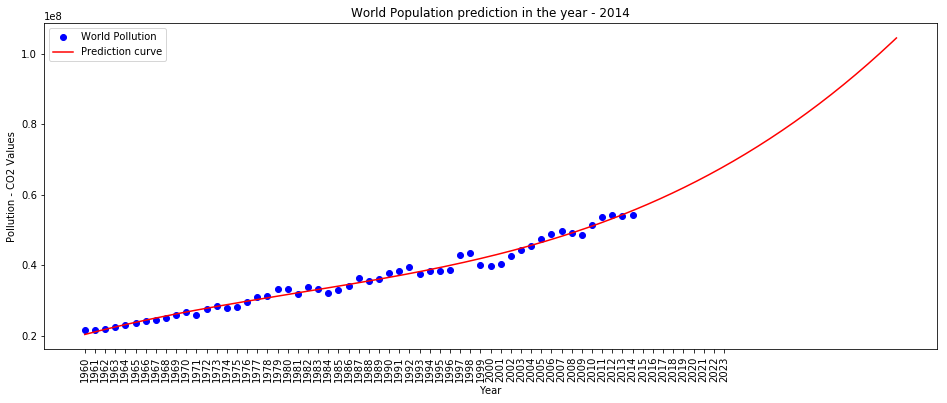

In [268]:
plt.figure(figsize=(16,6))
plt.plot(range(len(sum)),sum,'o',c='b',label='World Pollution')
plt.plot(line,predict_y,c='r',label='Prediction curve')
plt.xticks(range(len(year_list)),year_list,rotation = 90)
plt.xlabel('Year')
plt.ylabel('Pollution - CO2 Values')
plt.legend(loc='best')
_=plt.title('World Population prediction in the year - {}'.format(sum.index.values[-1]))